# EDA notebook
competition : RSNA Screening Mammography Breast Cancer Detection  
url : https://www.kaggle.com/competitions/rsna-breast-cancer-detection

reference notebook : https://www.kaggle.com/code/craigmthomas/rsna-2022-eda

## 0. import and Data loading

In [1]:
!pip install -qU python-gdcm pydicom pylibjpeg
!pip install japanize-matplotlib

import os
import copy
import random
import pydicom
import pandas as pd
import seaborn as sns
import japanize_matplotlib
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=6c872794c372c6ec2f251747df1cf7c25fbd3ecc5aaed673ce4e9eb7b96e2172
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [2]:
train = pd.read_csv("../input/rsna-breast-cancer-detection/train.csv")
test = pd.read_csv("../input/rsna-breast-cancer-detection/test.csv")

print('train')
display(train)
print('test')
display(test)

train


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


test


,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [3]:
print('---train---')
print(f'train.shape : {train.shape[0]}rows, {train.shape[1]}cols')
print(f'train.patient_id.nunique() : {train.patient_id.nunique()}')
print(f'train.image_id.nunique() : {train.image_id.nunique()}')
print(f'target col : cancer')
print(f'columns not in test : {set(train.columns) - set(test.columns)}')
display(train.describe(include='all'))
print(f'train missing values : ')
print(train.isnull().sum())
print('')
print('---test---')
print(f'test.shape : {test.shape[0]}rows, {test.shape[1]}cols')
print(f'columns not in train : {set(test.columns)-set(train.columns)}')

---train---
train.shape : 54706rows, 14cols
train.patient_id.nunique() : 11913
train.image_id.nunique() : 54706
target col : cancer
columns not in test : {'biopsy', 'BIRADS', 'difficult_negative_case', 'invasive', 'density', 'cancer'}


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
count,54706.000000,54706.000000,5.470600e+04,54706,54706,54669.000000,54706.000000,54706.000000,54706.000000,26286.000000,54706.000000,29470,54706.000000,54706
unique,NaN,NaN,NaN,2,6,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,2
top,NaN,NaN,NaN,R,MLO,NaN,NaN,NaN,NaN,NaN,NaN,B,NaN,False
freq,NaN,NaN,NaN,27439,27903,NaN,NaN,NaN,NaN,NaN,NaN,12651,NaN,47001
mean,1.460407,32698.865262,1.079386e+09,NaN,NaN,58.543928,0.021168,0.054272,0.014953,0.772350,0.026999,NaN,54.618378,NaN
std,0.498434,18893.861534,6.183269e+08,NaN,NaN,10.050884,0.143944,0.226556,0.121365,0.590062,0.162081,NaN,44.784800,NaN
min,1.000000,5.000000,6.849100e+04,NaN,NaN,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,21.000000,NaN
25%,1.000000,16481.000000,5.458153e+08,NaN,NaN,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,29.000000,NaN
50%,1.000000,32432.000000,1.082689e+09,NaN,NaN,59.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN,49.000000,NaN
75%,2.000000,48999.000000,1.613228e+09,NaN,NaN,66.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN,49.000000,NaN


train missing values : 
site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64

---test---
test.shape : 4rows, 9cols
columns not in train : {'prediction_id'}


**ここまででわかったこと**  
* trainには54706行存在しているが、患者数は11913である。１人の患者さんにつき複数のデータがある。
* trainにはtestにはないカラムが存在している。（testにもtrainにないカラムが一つ存在しているが、submit時に使用するだけで、あまり関係ない）
* testは１人の患者さんの４枚の画像からガンがあるかどうかを予測する。２つのview（？）で左右の胸の画像がある。よって計４画像
* 欠損値はあるが、ageだけtestデータに含まれているので、ageの処理を考えればOK、たぶん
  
**これからやること**
* 14つの特徴について、データの分布やそのデータの意味を理解する。
* testにないカラムも調べ、予測に使えるかどうかを考える。


## 1. image data

In [4]:
dcm_count = 0
for cdir, dirs, files in os.walk('../input/rsna-breast-cancer-detection/train_images'):
    for f in files:
        if f.split('.')[1] == 'dcm':
            dcm_count += 1
print(f'number of images .dcm : {dcm_count}')
print(f'number of images : {train.image_id.nunique()}')

number of images .dcm : 54706
number of images : 54706


すべての画像は.dcm形式であると考えられる。そもそも.dcm形式とはなんなのか  
  
**.DCM**  
>  DCMの画像フォーマットもDICOM画像フォーマットを開発し全国電機製造業者協会（NEMA）によって開発された。 NEMAは、DICOM医用画像保管、流通および分析のための標準仕様としてDCM形式を開発しました。 DCMフォーマットは、超音波画像、MRI（磁気共鳴画像）などのうちのCT（コンピュータ断層撮影）スキャンシートを含むことができる画像を保存するために使用される。これらDCMファイルの内容は、患者の氏名等の患者の詳細、および他の関連する医療データをも含むことができる。https://www.reviversoft.com/ja/file-extensions/dcm  

今回はMRI画像であるため、.dcm形式の画像である。また、.dcmには患者の氏名等の患者の詳細、およびほかの関連する医療データを含んでいるため、特徴として使える可能性がある。  
pythonで.dcmを扱うにはpydicomライブラリが必要である。

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '183901.792591'
(0010, 0020) Patient ID                          LO: '10006'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.10006
(0020, 000e) Series Instance

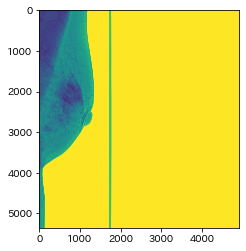

In [5]:
file = pydicom.dcmread('/kaggle/input/rsna-breast-cancer-detection/train_images/10006/1459541791.dcm')
print(file)
img = file.pixel_array
plt.imshow(img)
plt.show()

In [6]:
dicom_df = pd.read_csv('/kaggle/input/rsna-dicom-csv/dicom.csv').drop(columns="Unnamed: 0")
dicom_df.head()

,patient_id,image_id,PixelIntensityRelationship,ExposureControlMode,WindowCenter,WindowWidth,LossyImageCompression,ContentDate,Rows,RescaleSlope,PixelSpacing,SeriesInstanceUID,ContentTime,BodyPartThickness,HighBit,PixelPaddingValue,ExposureControlModeDescription,BitsStored,RescaleType,BitsAllocated,InstanceNumber,RescaleIntercept,StudyInstanceUID,PartialView,PixelRepresentation,PatientID,Columns,PhotometricInterpretation,CompressionForce,PixelIntensityRelationshipSign,ImageLaterality,SamplesPerPixel,VOILUTFunction,SOPInstanceUID
0,10006,462822612,LOG,NaN,"[1802.310000, 1802.310000, 2020.704000, 1583.9...","[1091.970000, 1091.970000, 1091.970000, 1091.9...",0.0,20221118,5355,1.0,NaN,1.2.840.10009.1.2.3.10006.1,183901.561976,NaN,15,3204.0,NaN,16,US,16,462822612,0.0,1.2.840.10009.1.2.3.10006,NO,0,10006,4915,MONOCHROME1,NaN,1.0,L,1,SIGMOID,1.2.840.10009.1.2.3.10006.1.462822612
1,10006,1459541791,LOG,NaN,"[1802.310000, 1802.310000, 2020.704000, 1583.9...","[1091.970000, 1091.970000, 1091.970000, 1091.9...",0.0,20221118,5355,1.0,NaN,1.2.840.10009.1.2.3.10006.1,183901.792591,NaN,15,3044.0,NaN,16,US,16,1459541791,0.0,1.2.840.10009.1.2.3.10006,NO,0,10006,4915,MONOCHROME1,NaN,1.0,L,1,SIGMOID,1.2.840.10009.1.2.3.10006.1.1459541791
2,10006,1864590858,LOG,NaN,"[1802.310000, 1802.310000, 2020.704000, 1583.9...","[1091.970000, 1091.970000, 1091.970000, 1091.9...",0.0,20221118,5355,1.0,NaN,1.2.840.10009.1.2.3.10006.1,183901.986648,NaN,15,3076.0,NaN,16,US,16,1864590858,0.0,1.2.840.10009.1.2.3.10006,NO,0,10006,4915,MONOCHROME1,NaN,1.0,R,1,SIGMOID,1.2.840.10009.1.2.3.10006.1.1864590858
3,10006,1874946579,LOG,NaN,"[1802.310000, 1802.310000, 2020.704000, 1583.9...","[1091.970000, 1091.970000, 1091.970000, 1091.9...",0.0,20221118,5355,1.0,NaN,1.2.840.10009.1.2.3.10006.1,183902.142082,NaN,15,3044.0,NaN,16,US,16,1874946579,0.0,1.2.840.10009.1.2.3.10006,NO,0,10006,4915,MONOCHROME1,NaN,1.0,R,1,SIGMOID,1.2.840.10009.1.2.3.10006.1.1874946579
4,10011,220375232,LOG,NaN,2048,4096,0.0,20221118,2776,1.0,NaN,1.2.840.10009.1.2.3.10011.1,183903.112791,NaN,11,0.0,NaN,12,US,16,220375232,0.0,1.2.840.10009.1.2.3.10011,NO,0,10011,2082,MONOCHROME2,NaN,1.0,L,1,NaN,1.2.840.10009.1.2.3.10011.1.220375232


途中

## 2. train feature
trainカラムについてそれぞれ見ていく

In [7]:
train.corr()

,site_id,patient_id,image_id,age,cancer,biopsy,invasive,BIRADS,implant,machine_id,difficult_negative_case
site_id,1.000000,-0.001236,-0.000508,0.128149,-0.009975,-0.121886,-0.002603,-0.430987,-0.153870,-0.446908,-0.090292
patient_id,-0.001236,1.000000,0.001124,-0.011810,-0.003253,-0.005848,-0.003762,0.011424,-0.004338,-0.002665,-0.004221
image_id,-0.000508,0.001124,1.000000,-0.007483,0.000223,0.001518,0.002657,-0.009201,0.004602,-0.006546,0.009850
age,0.128149,-0.011810,-0.007483,1.000000,0.075155,0.010167,0.068674,0.048258,-0.069599,-0.050258,-0.104224
cancer,-0.009975,-0.003253,0.000223,0.075155,1.000000,0.613872,0.837815,-0.210718,-0.014311,-0.024888,-0.059541
biopsy,-0.121886,-0.005848,0.001518,0.010167,0.613872,1.000000,0.514311,-0.410620,-0.002569,-0.017580,0.323064
invasive,-0.002603,-0.003762,0.002657,0.068674,0.837815,0.514311,1.000000,-0.172750,-0.008443,-0.018867,-0.049884
BIRADS,-0.430987,0.011424,-0.009201,0.048258,-0.210718,-0.410620,-0.172750,1.000000,0.025262,0.181352,-0.833624
implant,-0.153870,-0.004338,0.004602,-0.069599,-0.014311,-0.002569,-0.008443,0.025262,1.000000,0.018106,0.021065
machine_id,-0.446908,-0.002665,-0.006546,-0.050258,-0.024888,-0.017580,-0.018867,0.181352,0.018106,1.000000,0.000682


### 2.1 site_id

`site_id` - ID code for the source hospital.(ソース病院の ID コード。)
* 病院によってがん発見率が変わる？
* 特徴として入れるのはよくない（のか？）

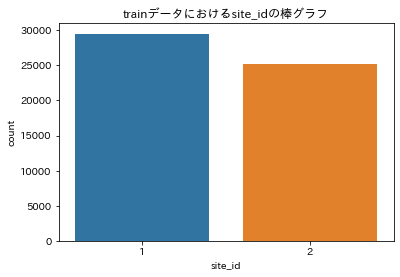

,0,1,sum,1/sum
site_id_1,28855,664,29519,0.022494
site_id_2,24693,494,25187,0.019613


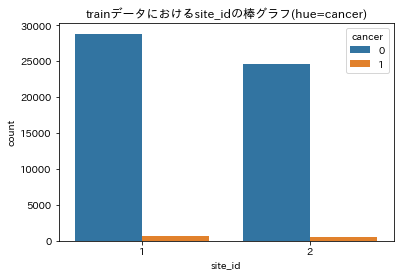

In [8]:
p = sns.countplot(x='site_id', data=train)
p.set(title='trainデータにおけるsite_idの棒グラフ')
plt.show()

_ = train.groupby('site_id')['cancer'].value_counts()
tmp = pd.DataFrame(index=['site_id_1', 'site_id_2'], data={'0': [_[1][0], _[2][0]], '1': [_[1][1], _[2][1]] })
tmp['sum'] = tmp['0'] + tmp['1']
tmp['1/sum'] = tmp['1'] / tmp['sum']
display(tmp)

p = sns.countplot(x='site_id', data=train, hue='cancer')
p.set(title='trainデータにおけるsite_idの棒グラフ(hue=cancer)')
plt.show()

`site_id`はとりあえず無視する。  
見た感じ、どちらの病院のほうががん発見率が高い、といったことはない。

追記：  
ディスカッションでsite_idごとのモデルを作成していた  
site_idごとにモデルを分けたほうがいいのか

### 2.2 patient_id, image_id

`patient_id, image_id`に関してはただのIDであるため無視

### 2.3 laterality

`laterality` - Whether the image is of the left or right breast.（画像が左胸か右胸か）

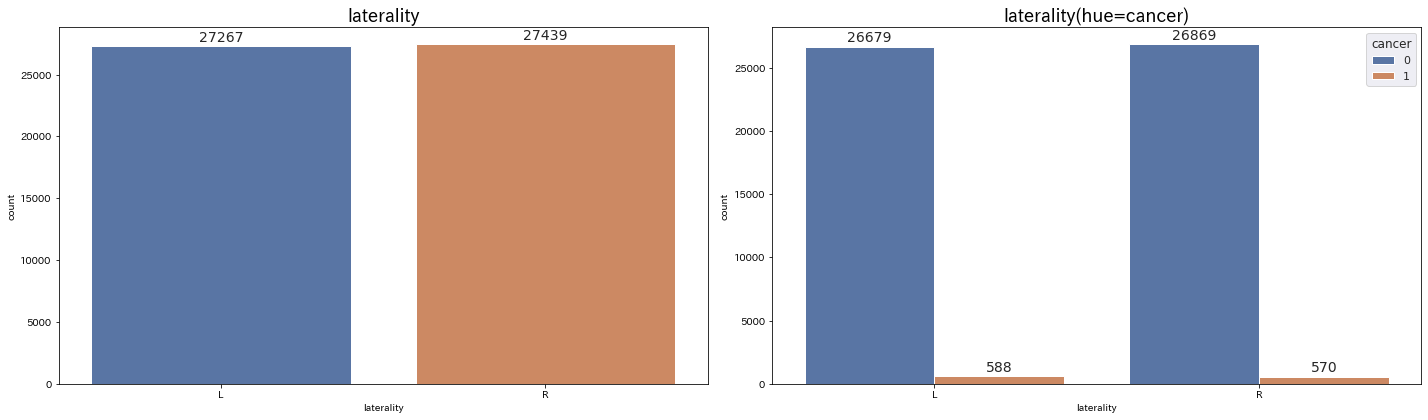

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize =(20,6), tight_layout=True)
sns.set()
# axs = axs.flatten()

sns.countplot(x='laterality', data=train, ax=axs[0])
axs[0].set_title('laterality', fontsize=18)

for p in axs[0].patches:
    axs[0].annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., 
                    p.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize = 14)

sns.countplot(x='laterality', data=train, hue='cancer', ax=axs[1])
axs[1].set_title('laterality(hue=cancer)', fontsize=18)
for q in axs[1].patches:
    axs[1].annotate(format(q.get_height()), 
                   (q.get_x() + q.get_width() / 2., 
                    q.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize = 14)
plt.show()



左右でがんの発見に相関はなさそう

### 2.4 view
`view` - The orientation of the image. The default for a screening exam is to capture two views per breast.(画像の向き。スクリーニング検査のデフォルトでは、乳房ごとに 2 つのビューをキャプチャします。)

MLO    27903
CC     26765
AT        19
LM        10
ML         8
LMO        1
Name: view, dtype: int64

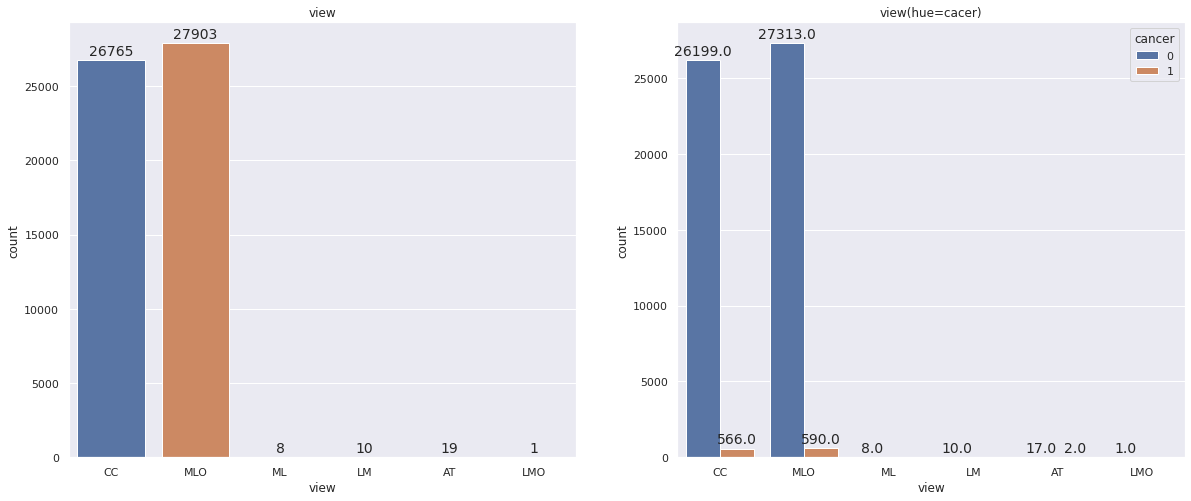

In [10]:
display(train.view.value_counts())
fig ,axs = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
sns.set()

sns.countplot(x='view', data=train, ax=axs[0])
axs[0].set(title='view')
for q in axs[0].patches:
    axs[0].annotate(format(q.get_height()), 
                   (q.get_x() + q.get_width() / 2., 
                    q.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize = 14)

sns.countplot(x='view', data=train, hue='cancer', ax=axs[1])
axs[1].set(title='view(hue=cacer)')

for q in axs[1].patches:
    axs[1].annotate(format(q.get_height()), 
                   (q.get_x() + q.get_width() / 2., 
                    q.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize = 14)

plt.show()

* CCとMLOが圧倒的に多い
* それぞれのviewの画像を見る必要がありそう
* ML,LM,LMOに関してはがんの発見がない


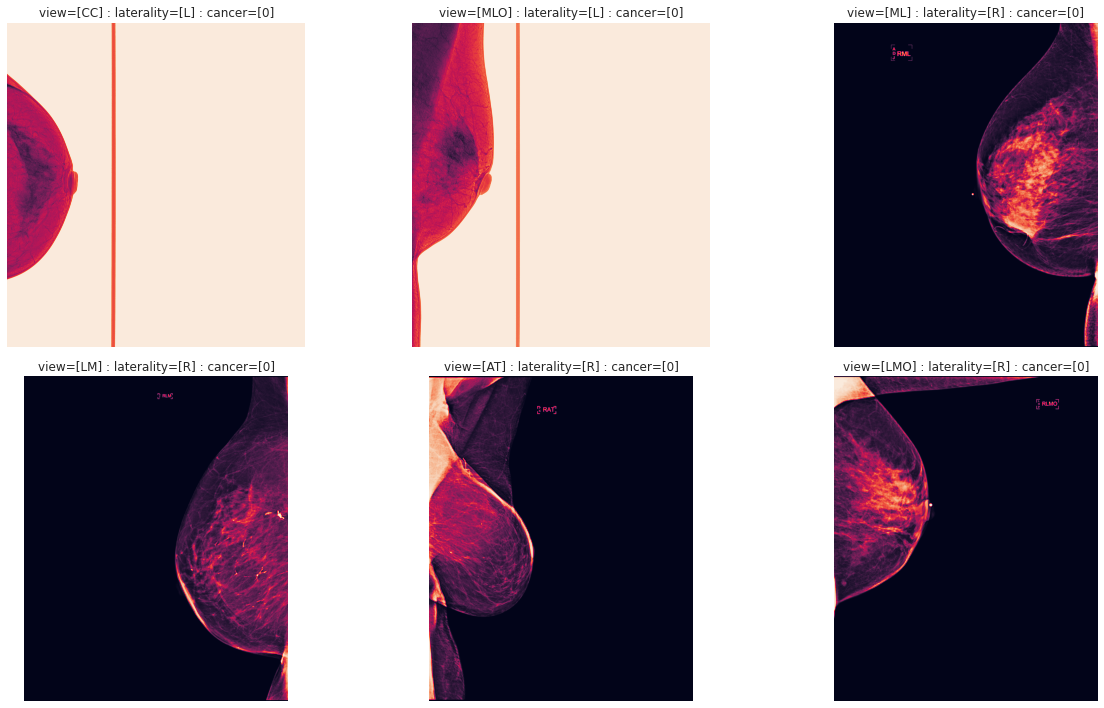

In [11]:
def get_dcm_img(patient_id, image_id, tr_or_te='train_images'):
    path = '/kaggle/input/rsna-breast-cancer-detection/'+tr_or_te+'/'+str(patient_id)+'/'+str(image_id)+'.dcm'
    f = pydicom.dcmread(path)
    img = f.pixel_array
    return img.tolist()

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,10), tight_layout=True)
axs = axs.flatten()
for i, view_ in enumerate(train.view.unique().tolist()):
    t = train[train.view==view_].iloc[0]
    p_id = t.patient_id
    i_id = t.image_id
    l_or_r = t.laterality
    cancer = t.cancer
    img = get_dcm_img(p_id, i_id)
    axs[i].imshow(img)
    axs[i].set_title(f'view=[{view_}] : laterality=[{l_or_r}] : cancer=[{cancer}]')
    axs[i].axis('off')
    
    
plt.show()


* 画像を見ただけでは、大きな違いはわからない
* CC,MLOと他では画像サイズが違う（？）、背景色も異なっている
* CC,MLOには縦のラインが引かれている

以下、[参考ノートブック](https://www.kaggle.com/code/craigmthomas/rsna-2022-eda#3.1---View-Feature)より
* `MLO` - Mediolateral Oblique View
    * ほとんどの乳房組織をキャプチャします。胸筋がビューに含まれており、適切な患者のポジショニングと全体的な画質を評価するためのガイドとして使用されます。MLO ビューは下向きに撮影されていますが、胸の中心から外側を見るように角度が付けられています。
* `CC` - Craniocaudal View
    * 内外側斜めビューと同様に、胸筋がビューに含まれる場合があります。これは、適切な患者のポジショニングを評価するためのガイドとして使用されます。ただし、主な違いは、Crainocaudal ビューが乳房の上からまっすぐ下を向いて撮影されることです (つまり、斜めビューのように角度が導入されていません)。
  
MLOビューとCCビューはどちらも標準ビューとして知られている。これらのビューは通常のスクリーニング（症状が現れる前に病気の兆候を発見するための試み）で最も一般的に使用されるビューだが、疾患プロセスが存在する場合などは他のビューが使用されることもある。４０歳未満の場合、左と右のMLOのみを実施して全体的な放射線被爆を減らすことができる。これは、ほとんどの乳房組織を適切に捉えるためである。  

他のビューについて：  
* `AT` - unknown
    * 調査中
* `ML` - Mediolateral View
    * 胸の間の胸の中心から外側に向けて開く。通常、MLOビューが撮影されていないか、撮影できない場合に使用される。これは、斜めビューが利用できない場合に好まれるビュー。ほとんどの病気のプロセスは乳房の外側で発生し、したがってフィルムに近くなり、病理のより鮮明な画像が可能になる。
* `LM` - Lateromedial View
    * ビューが胸に向かって内側を指している腕から取られることを除いて、MLビューに似ている。このビューは、乳房の外側に病変が発生する傾向があるため、理想的ではない。
* `LMO` - Lateromedial Oblique View
    * 体の外側から内側を向いている点を除いて、MLO に似ている。


それぞれのviewについて画像を何枚か見ていく必要がありそう  
今回は画像処理がコンペの鍵だと考えられるため、深堀したほうがいい（？）

#### 2.4.1 CC view
* 上下で挟んで撮影

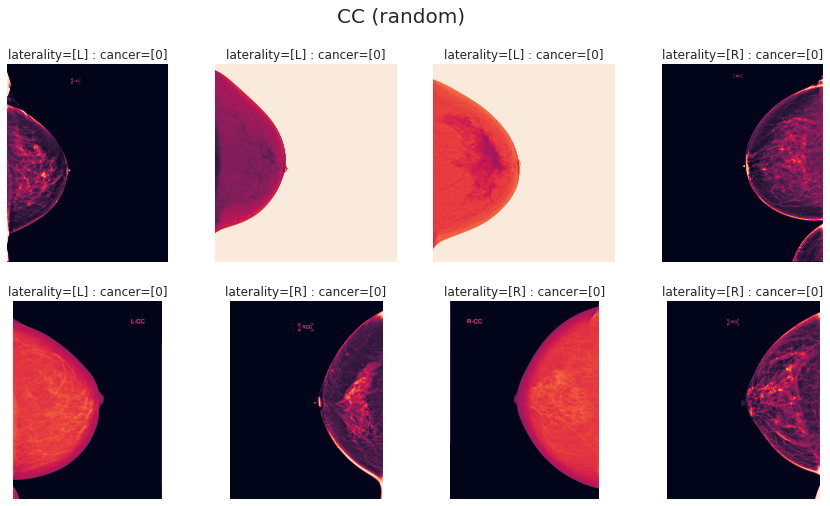

In [12]:
def show_view(view_name):
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,8))
    axs = axs.flatten()
    tmp = train[train.view==view_name]
    for i in range(8):
        try:
            n = random.randint(0, tmp.shape[0])
            t = tmp.iloc[n]
            p_id = t.patient_id
            i_id = t.image_id
            l_or_r = t.laterality
            cancer = t.cancer
            img = get_dcm_img(p_id, i_id)
            axs[i].imshow(img)
            axs[i].set_title(f'laterality=[{l_or_r}] : cancer=[{cancer}]')
            axs[i].axis('off')
        except:
            pass
    fig.suptitle(f'{view_name} (random)', fontsize=20)
show_view('CC')

#### 2.4.2 MLO view
* 縦方向で少し斜めに挟んで撮影

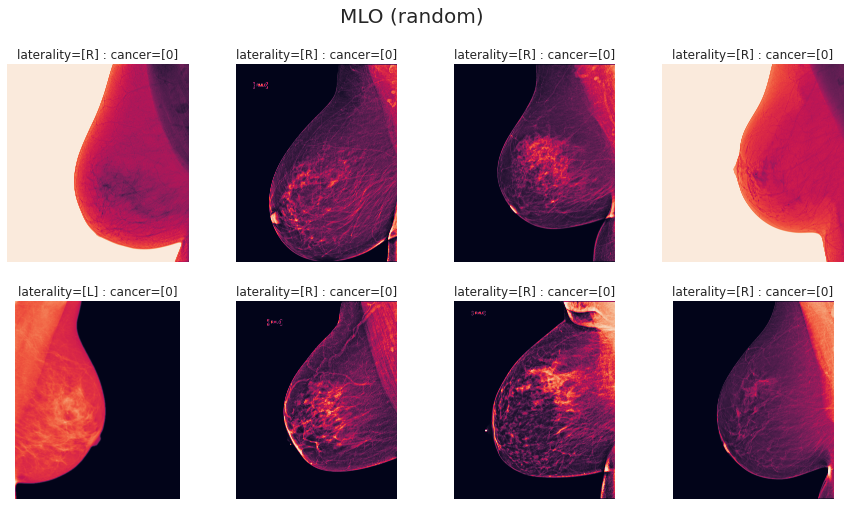

In [13]:
show_view('MLO')

#### 2.4.3 AT view

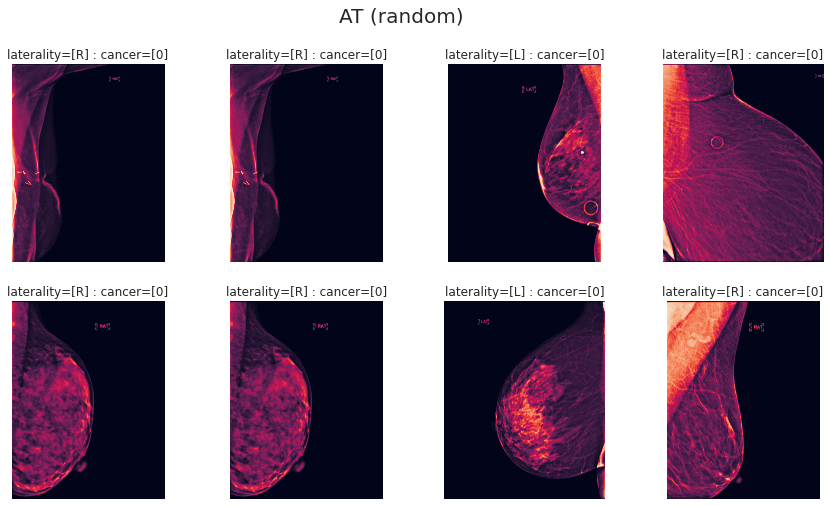

In [14]:
show_view('AT')

#### 2.4.4 ML view

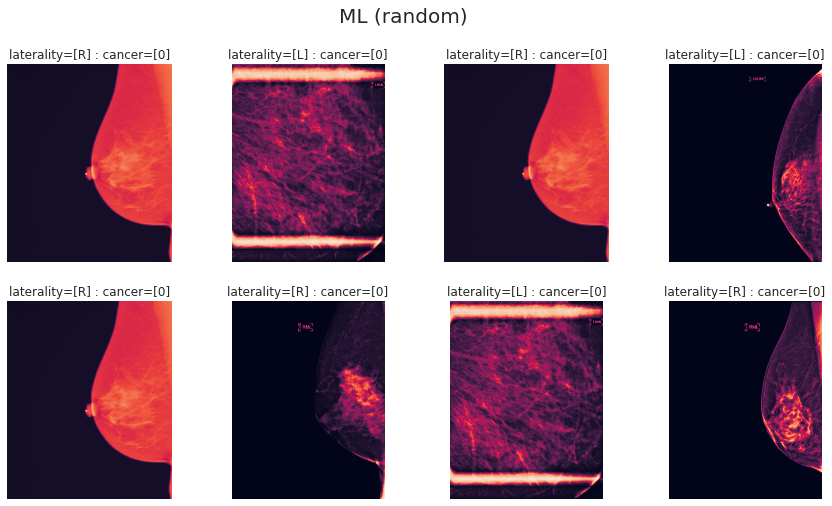

In [15]:
show_view('ML')

#### 2.4.5 LM view

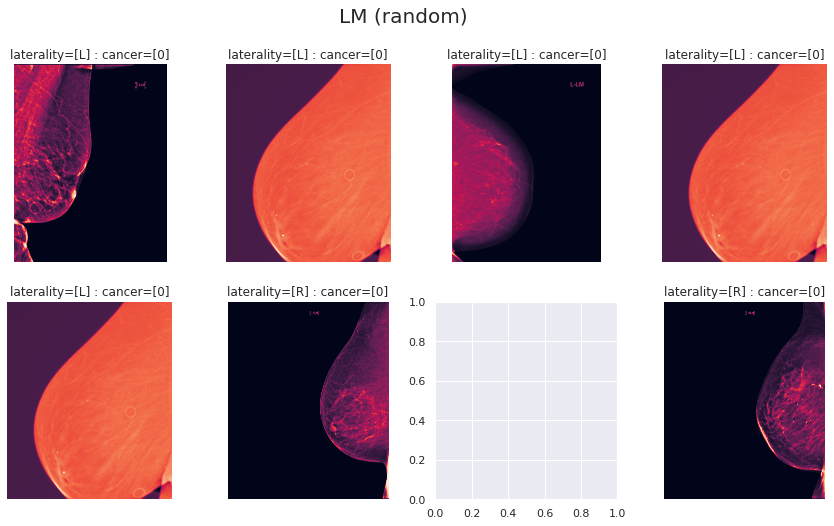

In [16]:
show_view('LM')

#### 2.4.6 LMO view
* LMOは一枚しかない

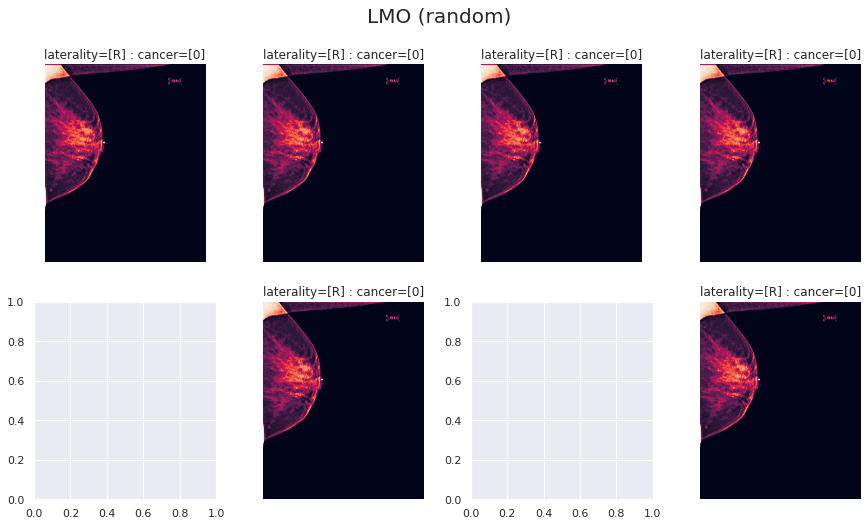

In [17]:
show_view('LMO')

### 2.5 age
`age` - 患者の年齢。

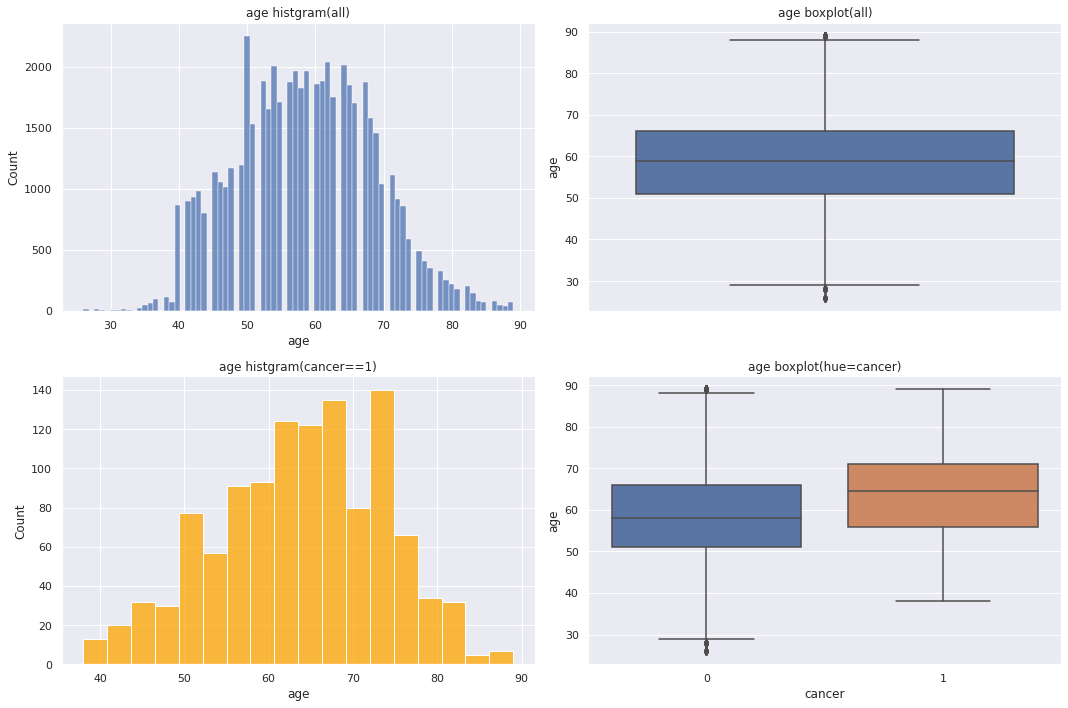

count    54669.000000
mean        58.543928
std         10.050884
min         26.000000
25%         51.000000
50%         59.000000
75%         66.000000
max         89.000000
Name: age, dtype: float64
ガンと診断された人の最低年齢：38.0歳


In [18]:
fig ,axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10), tight_layout=True)
axs = axs.flatten()
sns.histplot(data=train, x='age', ax=axs[0])
axs[0].set_title('age histgram(all)')

sns.boxplot(data=train, y='age', ax=axs[1])
axs[1].set_title('age boxplot(all)')

sns.histplot(data=train[train.cancer==1], x='age', ax=axs[2], color='orange')
axs[2].set_title('age histgram(cancer==1)')

sns.boxplot(data=train, y='age' , ax=axs[3], x='cancer' )
axs[3].set_title('age boxplot(hue=cancer)')

plt.show()

print(train.age.describe())
print(f'ガンと診断された人の最低年齢：{train[train.cancer==1].age.min()}歳')


* ガンと診断された人の年齢は高い傾向にある。
* 特徴としては十分に使用できると思う。
* ageには欠損値が存在するため、処理を考える必要がある。

In [19]:
print(f'age欠損値数：{train.age.isnull().sum()}')
print('ageの欠損値を含む行')
display(train[train.age.isnull()])

age欠損値数：37
ageの欠損値を含む行


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
1850,1,11995,1129509810,L,CC,NaN,0,0,0,1.0,0,D,49,False
1851,1,11995,1732220752,L,MLO,NaN,0,0,0,1.0,0,D,49,False
1852,1,11995,776998051,R,MLO,NaN,0,0,0,1.0,0,D,49,False
1853,1,11995,2123005479,R,CC,NaN,0,0,0,1.0,0,D,49,False
12886,1,23752,1081106657,L,CC,NaN,0,0,0,1.0,0,C,49,False
12887,1,23752,1106722394,L,MLO,NaN,0,0,0,1.0,0,C,49,False
12888,1,23752,707585829,R,MLO,NaN,0,0,0,1.0,0,C,49,False
12889,1,23752,1982432589,R,CC,NaN,0,0,0,1.0,0,C,49,False
16230,1,27212,598973621,L,MLO,NaN,0,0,0,NaN,0,D,49,False
16231,1,27212,660603973,L,CC,NaN,0,0,0,NaN,0,D,49,False


気になった点：
* site_idはすべて１
* machine_idはすべて49
* viewはCCかMLO

今のところは平均か中央値か、、、  
ageについてのディスカッションを探したほうがはやそう

### 2.6 cancer
**目的変数**

1が陽性,0が陰性（というか見つからなかった）

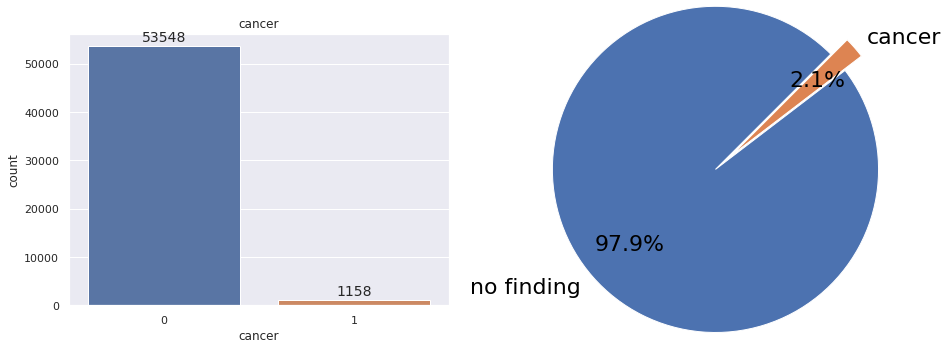

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.countplot(data=train, x='cancer', ax=axs[0])
axs[0].set_title('cancer')

for q in axs[0].patches:
    axs[0].annotate(format(q.get_height()), 
                   (q.get_x() + q.get_width() / 2., 
                    q.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize = 14)

sns.set()
label = ['no finding', 'cancer']
axs[1].pie(
    train.cancer.value_counts(),
    labels=label,
    startangle=45,
    autopct='%1.1f%%',
    pctdistance=0.7,
    radius=1.5,
    explode=[0, 0.2],
    textprops={ 'size': 22, 'color': 'black'}
)

plt.show()

* めちゃめちゃ不均衡データ
* アンダーサンプリング or オーバーサンプリング
* アンダーサンプリングが無難だが、画像をうまく水増しできればオーバーサンプリングも可能か

ほかにも不均衡データの対処法があるっぽい[url](https://qiita.com/tk-tatsuro/items/10e9dbb3f2cf030e2119)

とりあえずはアンダーサンプリングでモデルの学習を行い、余裕があれば画像データを水増ししてcancerのデータを２倍、３倍にして学習してみて、結果を比較するのもありかも

### 2.7 biopsy
`biopsy` - 乳房のフォローアップ生検が実施されたかどうか。  
* trainにのみある特徴  
* biopsy(生検)とは？

> 病理医による検査のために細胞または組織を採取すること。病理医はその組織を顕微鏡で調べたり、その細胞または組織に対して他の検査を実施したりする。
* biopsyを受けたほうがガンの発見がしやすい？

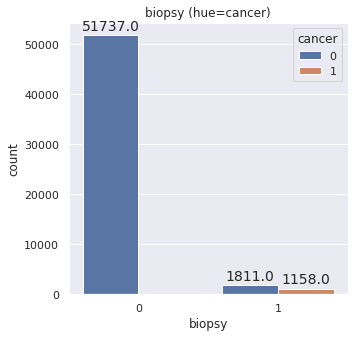

In [21]:
fig, ax = plt.subplots(figsize=(5,5))
sns.countplot(data=train, x='biopsy', hue='cancer', ax=ax)
for q in ax.patches:
    ax.annotate(format(q.get_height()), 
                   (q.get_x() + q.get_width() / 2., 
                    q.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize = 14)

ax.set_title('biopsy (hue=cancer)')
plt.show()

グラフから、
* biopsyが０（受けていない）の人で陽性と診断された人はいない
* １（受けた）の人ではだいたい半々の割合で陽性と診断されている
* というかbiopsyはがんの陽性を確定するために行われるらしい

とりあえず放置

### 2.8 invasive
`invasive` - 乳房ががんに対して陽性である場合、がんが浸潤性であることが判明したかどうか。
* trainのみ
* 非浸潤がん
> がんが、最初に発生する乳管・小葉にまだとどまっている状態のものです。
がんを取り切ることができれば、ほとんどで完治が見込まれます。ただし非浸潤がんであってもがんの範囲が広い場合は、がんを取り切るために乳房をすべて切除しなければならないこともあります。

* 浸潤がん
> がんが乳管・小葉を越えて、乳管の外の間質にまで広がっているものです。
がんの進行度を表すステージによって治療の流れや目的は異なりますが、遠隔転移がなければ治癒を目指した治療の対象となります。
  
がんと診断された人のなかでも浸潤がんと非浸潤がんに分けられる。非浸潤がんなら取り除ける可能性が高い。

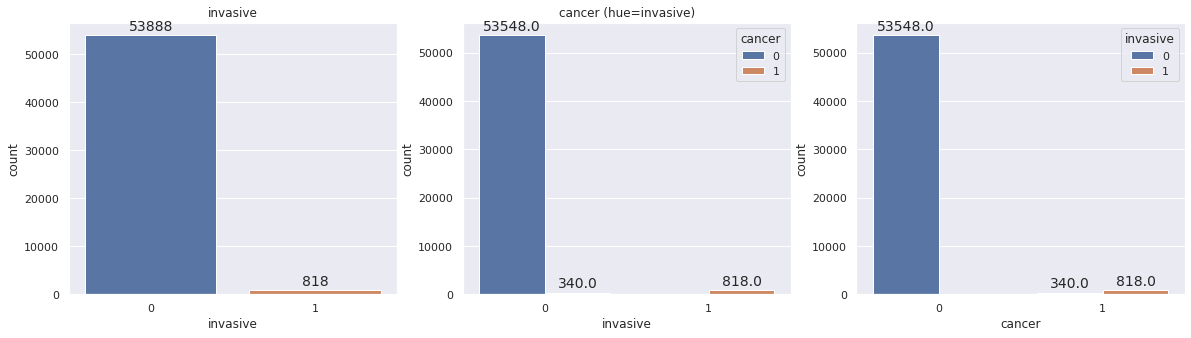

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

sns.countplot(data=train, x='invasive', ax=axs[0])
for q in axs[0].patches:
    axs[0].annotate(format(q.get_height()), 
                   (q.get_x() + q.get_width() / 2., 
                    q.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize = 14)
axs[0].set_title('invasive')

sns.countplot(data=train, x='invasive', ax=axs[1], hue='cancer')
for q in axs[1].patches:
    axs[1].annotate(format(q.get_height()), 
                   (q.get_x() + q.get_width() / 2., 
                    q.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize = 14)
axs[1].set_title('invasive (hue=cancer)')

sns.countplot(data=train, x='cancer', ax=axs[2], hue='invasive')
for q in axs[2].patches:
    axs[2].annotate(format(q.get_height()), 
                   (q.get_x() + q.get_width() / 2., 
                    q.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize = 14)
axs[1].set_title('cancer (hue=invasive)')
plt.show()

* 当たり前かもしれないが、がんが発見されなかった人はみんな浸潤がんとは診断されていない（そもそもがんではない）  
今のところ使う場面はない（？）  

### 2.9 BIRADS
`BIRADS` - 乳房がフォローアップを必要とした場合は 0、乳房が癌に対して陰性と評価された場合は 1、乳房が正常と評価された場合は 2。  
`BIRADS`カラムはBI-RADSスコアを表しているらしい。  
0 - Need additional imaging evaluation  
1 - Negative  
2 - Benign  
3 - Probably Benign  
4 - Suspicious  
5 - Highly Suggestive of Malignancy  
6 - Known Biopsy-Proven Malignancy  
参考ノートブック：https://www.kaggle.com/competitions/rsna-breast-cancer-detection/discussion/369262

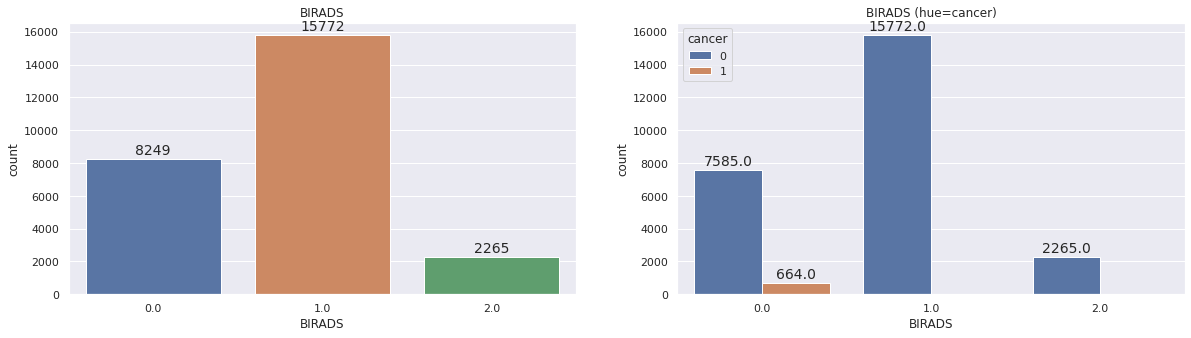

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.countplot(data=train, x='BIRADS', ax=axs[0])
for q in axs[0].patches:
    axs[0].annotate(format(q.get_height()), 
                   (q.get_x() + q.get_width() / 2., 
                    q.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize = 14)
axs[0].set_title('BIRADS')

sns.countplot(data=train, x='BIRADS', hue='cancer', ax=axs[1])
for q in axs[1].patches:
    axs[1].annotate(format(q.get_height()), 
                   (q.get_x() + q.get_width() / 2., 
                    q.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize = 14)
axs[1].set_title('BIRADS (hue=cancer)')
    
plt.show()

* とりあえず０は異常（追加検査が必要）、１と２は正常らしい
* ただ、０だからと言ってがんであるとは言えない
* ちなみにcancer=1の値が少ないのはBIRADSの欠損値があるから

BIRDASの予測モデルを作成して、それをtestの特徴量として使うのもあり（？）

### 2.10 implant
`implant` - 患者が豊胸手術を受けたかどうか。サイト 1 は、乳房レベルではなく、患者レベルで乳房インプラント情報のみを提供します。  
「サイト１は、乳房レベルではなく、患者レベルで乳房インプラント情報のみを提供します。」？？？  



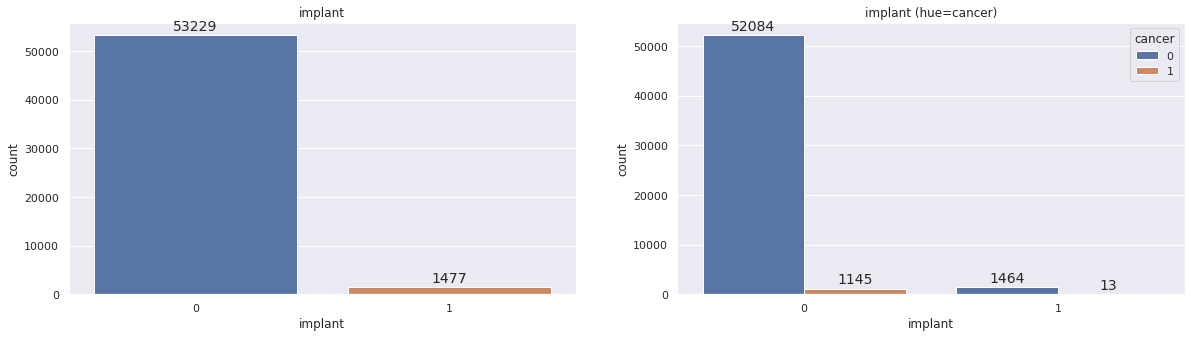

Text(0.5, 0.98, 'implant==1 images')

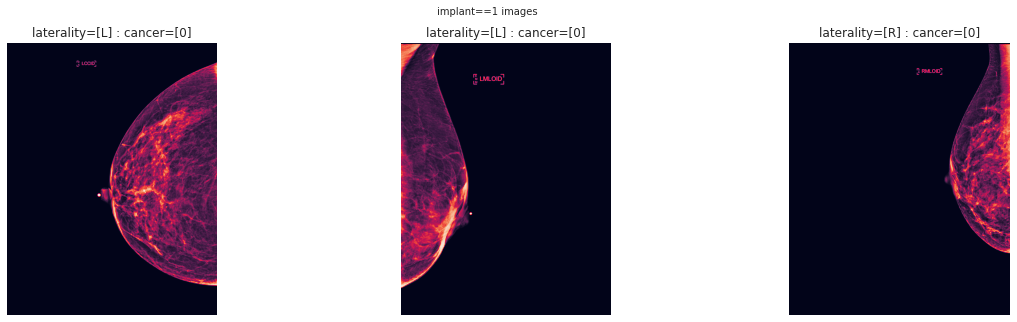

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

sns.countplot(data=train, x='implant', ax=axs[0])
for q in axs[0].patches:
    axs[0].annotate(format(q.get_height()), 
                   (q.get_x() + q.get_width() / 2., 
                    q.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize = 14)
axs[0].set_title('implant')

sns.countplot(data=train, x='implant', hue='cancer', ax=axs[1])
for q in axs[1].patches:
    axs[1].annotate(format(q.get_height()), 
                   (q.get_x() + q.get_width() / 2., 
                    q.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize = 14)
axs[1].set_title('implant (hue=cancer)')
plt.show()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
for i in range(3):
    n = random.randint(0,1477)
    tmp = train[train.implant==1].iloc[n]
    p_id = tmp.patient_id
    i_id = tmp.image_id
    l_or_r = tmp.laterality
    cancer = tmp.cancer
    img = get_dcm_img(p_id, i_id)
    axs[i].imshow(img)
    axs[i].set_title(f'laterality=[{l_or_r}] : cancer=[{cancer}]')
    axs[i].axis('off')
fig.suptitle('implant==1 images', fontsize=10)


In [25]:
tmp = pd.crosstab(train['implant'], train['cancer'],margins=True)
tmp['0/All'] = tmp[0] / tmp['All']
tmp['1/All'] = tmp[1] / tmp['All']
tmp = tmp.drop(index='All')
display(tmp)
print('implant==0の人でがんの人の割合：{}%'.format(round(tmp.loc[0,'1/All']*100,2)))
print('implant==1の人でがんの人の割合：{}%'.format(round(tmp.loc[1,'1/All']*100,2)))

cancer,0,1,All,0/All,1/All
implant,,,,,
0,52084,1145,53229,0.978489,0.021511
1,1464,13,1477,0.991198,0.008802


implant==0の人でがんの人の割合：2.15%
implant==1の人でがんの人の割合：0.88%


* 豊胸手術を受けた人は、受けてない人よりがんの割合が低い
* 決定木で分類する際はimplantありとなしの場合で結果を比較したほうがいい
* implant==1の人は少ないため、モデルがどのように評価するかわからない

### 2.11 density
`density` - 乳房組織の密度の評価。A が最も密度が低く、D が最も密度が高い。非常に密度の高い組織は、診断をより困難にする可能性があります。trainのみ  



(0.0, 1.0, 0.0, 1.0)

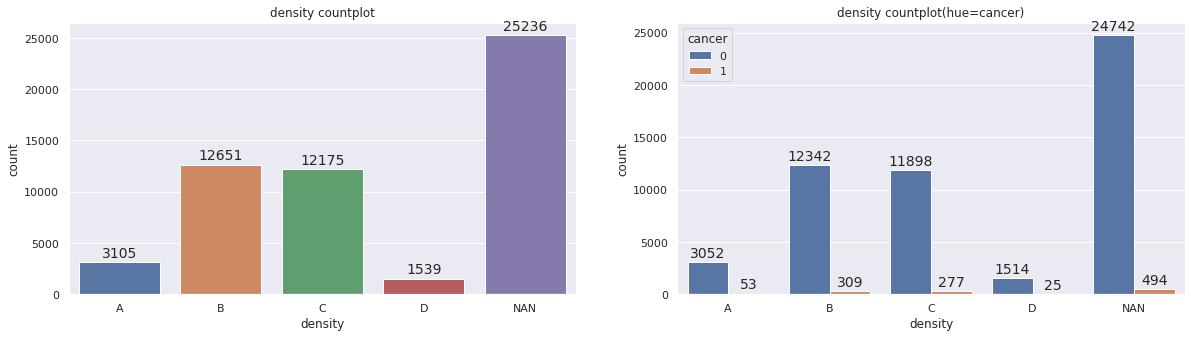

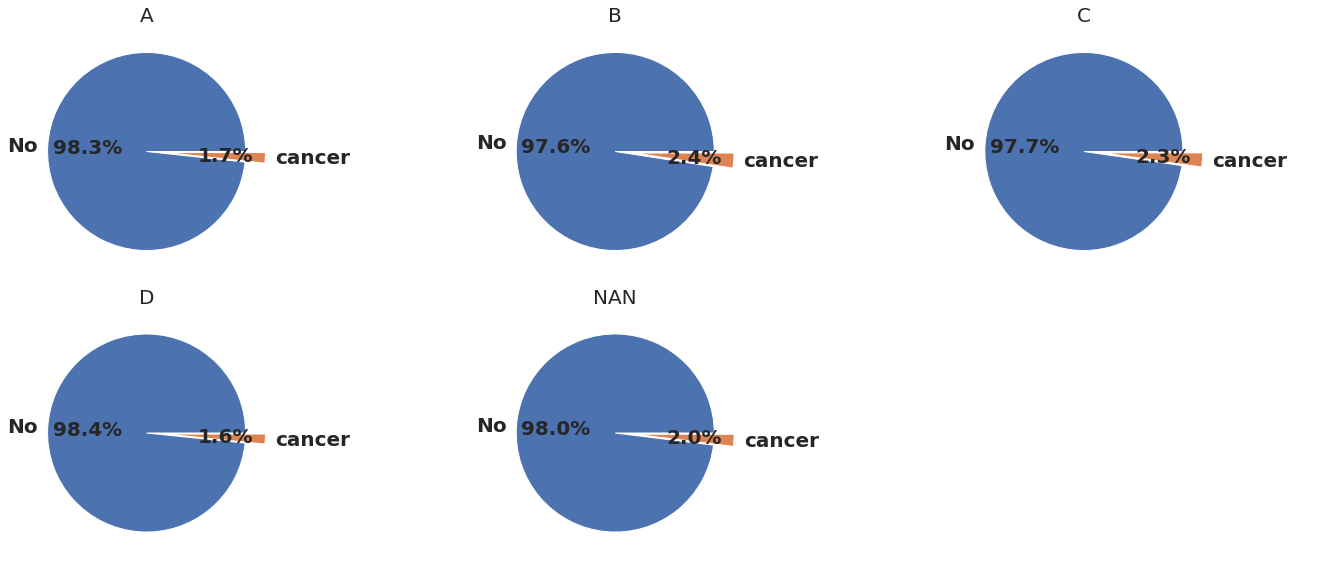

In [26]:
fig, axs =plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
train_ = train.copy()
train_['density'] = train['density'].fillna('NAN')
sns.countplot(data=train_, x='density', ax=axs[0], order=['A','B','C','D', 'NAN'])
for q in axs[0].patches:
    axs[0].annotate(format(q.get_height()), 
                   (q.get_x() + q.get_width() / 2., 
                    q.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize = 14)
axs[0].set_title('density countplot')

sns.countplot(data=train_, x='density', ax=axs[1],hue='cancer', order=['A','B','C','D', 'NAN'])
for q in axs[1].patches:
    axs[1].annotate(format(q.get_height()), 
                   (q.get_x() + q.get_width() / 2., 
                    q.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize = 14)
axs[1].set_title('density countplot(hue=cancer)')


tmp = pd.crosstab(train_['density'], train_['cancer'])

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,8), tight_layout=True)
axs = axs.flatten()
for n,i in enumerate(['A', 'B', 'C', 'D', 'NAN']):
    x = tmp.loc[i].tolist()
    axs[n].pie(x, labels=['No','cancer'], autopct='%1.1f%%', explode=[0, 0.2], textprops={'weight': 'bold', 'size': 20})
    axs[n].set_title(i, fontsize=20)
axs[5].axis('off')

画像を見てみる

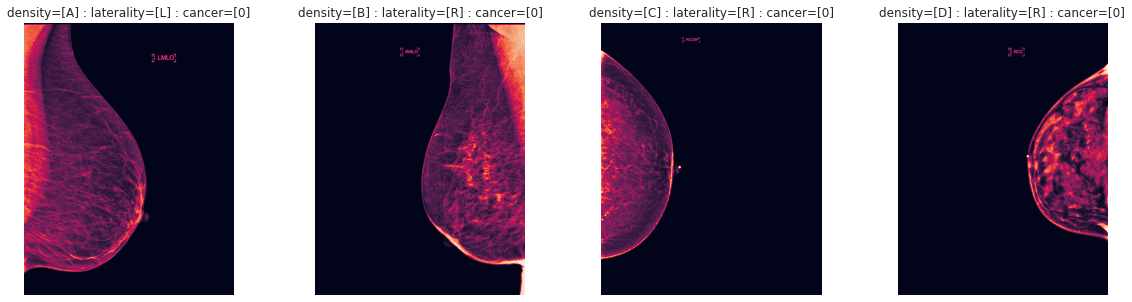

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
axs = axs.flatten()
for n, i in enumerate(['A', 'B', 'C', 'D']):
    tmp = train[(train.density==i)&(train.implant==0)]
    tmp_ = tmp.iloc[random.randint(0, tmp.shape[0])]
    p_id = tmp_.patient_id
    i_id = tmp_.image_id
    l_or_r = tmp_.laterality
    cancer = tmp_.cancer
    img = get_dcm_img(p_id, i_id)
    axs[n].imshow(img)
    axs[n].set_title(f'density=[{i}] : laterality=[{l_or_r}] : cancer=[{cancer}]')
    axs[n].axis('off')

* densityは欠損値が多く、一応dicomファイルにあるCompressionForce and BodyPartThicknessから補完できるみたいだけど、trainで欠損しているところはそのdicomファイルのデータも欠損しているらしい、
* 用途としては、BIRADSスコアを予測するときなどに使えるかもしれない

### 2.12 machine_id
`machine_id` - イメージング デバイスの ID コード  


Text(0.5, 1.0, 'machine_id countplot (hue=cancer)')

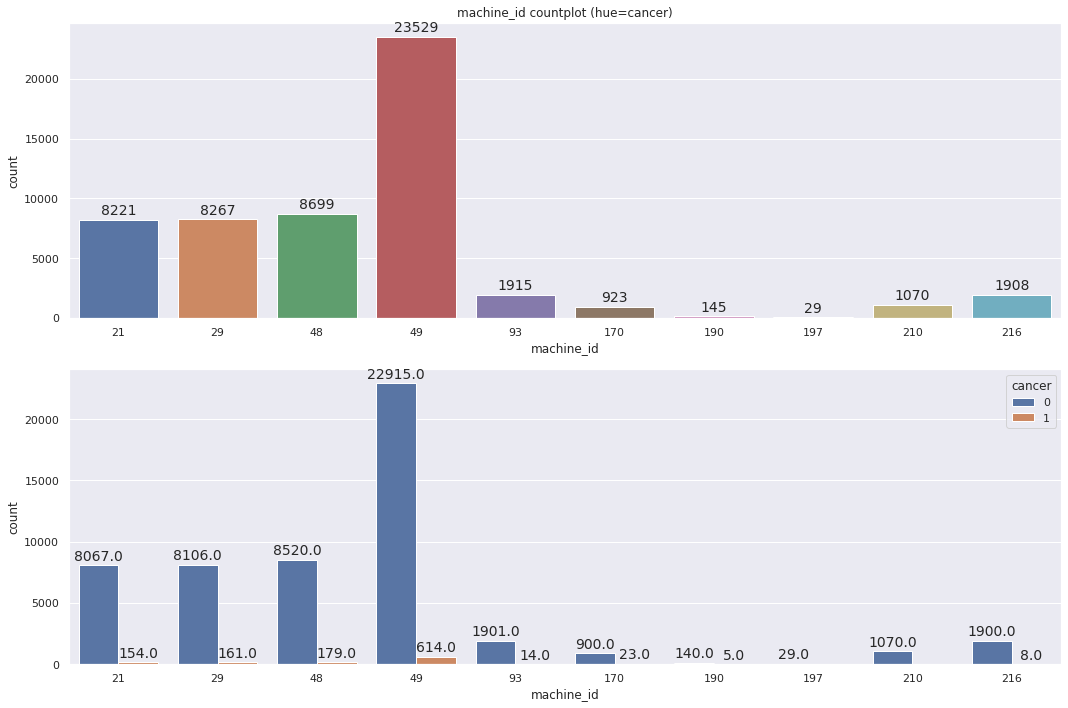

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), tight_layout=True)
axs = axs.flatten()
sns.countplot(data=train, x='machine_id', ax=axs[0])
for q in axs[0].patches:
    axs[0].annotate(format(q.get_height()), 
                   (q.get_x() + q.get_width() / 2., 
                    q.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize = 14)
axs[0].set_title('machine_id countplot')

sns.countplot(data=train, x='machine_id', ax=axs[1], hue='cancer')
for q in axs[1].patches:
    axs[1].annotate(format(q.get_height()), 
                   (q.get_x() + q.get_width() / 2., 
                    q.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize = 14)
axs[0].set_title('machine_id countplot (hue=cancer)')

特に言うことはない（？）

### 2.13 difficult_negative_case
`difficult_negative_case` - ケースが非常に困難な場合は true。trainのみ

Text(0.5, 1.0, 'difficult_negative_case countplot(hue=cancer)')

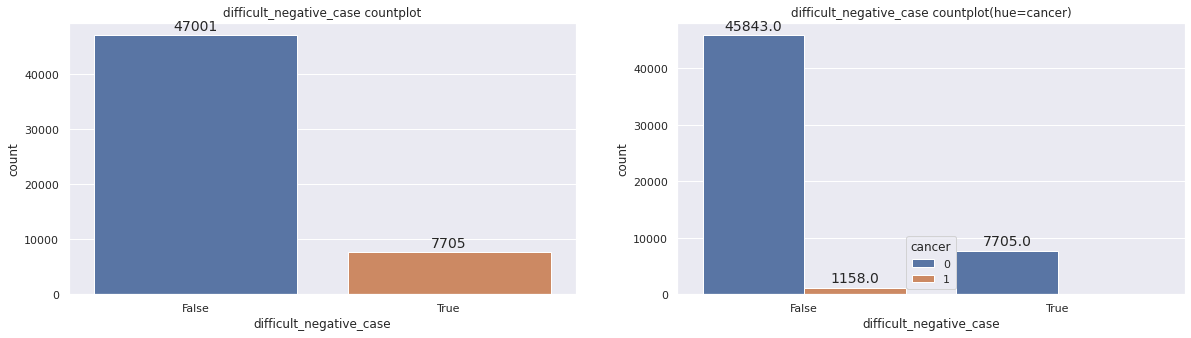

In [29]:
fig, axs =plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
sns.countplot(data=train, x='difficult_negative_case', ax=axs[0])
for q in axs[0].patches:
    axs[0].annotate(format(q.get_height()), 
                   (q.get_x() + q.get_width() / 2., 
                    q.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize = 14)
axs[0].set_title('difficult_negative_case countplot')

sns.countplot(data=train, x='difficult_negative_case', ax=axs[1],hue='cancer')
for q in axs[1].patches:
    axs[1].annotate(format(q.get_height()), 
                   (q.get_x() + q.get_width() / 2., 
                    q.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize = 14)
axs[1].set_title('difficult_negative_case countplot(hue=cancer)')

* Trueの場合、がんの人はいない
* なにか使えそうだけど、とりあえず放置

## 3. Tips

### 3.1 About Mammography
参考：https://www.kaggle.com/competitions/rsna-breast-cancer-detection/discussion/369262  
https://www.ncc.go.jp/jp/ncch/division/radiological_technology/radiological_diagnosis/xsenkensa/020/020.html  
  
#### mammographyとは
* マンモグラフィとは女性の乳がん検診に最適な画像診断法で、乳房専用のX線検査のこと。
* 乳房を板で圧迫し、薄く伸ばした状態で撮影する
* 乳房全体を写し出すために、複数の方向（view）から圧迫し撮影する
* 乳房を薄く伸ばすことで乳腺が広がり、腫瘤性の病変がより鮮明に観察可能となる。またマンモグラフィでは、乳房を触ってもしこりがわからないようなタイプの乳がんも、白い点のように見える微細石灰化病変として見つけることができる。
* マンモグラフィは、特にこの石灰化を見つけることに有用な検査。

これから
* viewについて深堀
* 画像処理を考える、実際にプログラムも書く
* 相関に関することやってみる　https://istat.co.jp/sk_commentary/correlation-test/type
* P値とか見てみる